In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter
from elasticsearch import Elasticsearch
from elasticsearch import helpers

In [2]:
df = pd.read_csv('byArticle-JSEN-201801-202309-New.csv', encoding='utf-8')

In [3]:
df = df.drop(['Rank', '1st Author Name', 'Volume Number', 'Issue Number', 'Content Type', 'Online Publish Year', 'Print Publish Year', 'Open Access', 'PDF Downloads', 'HTML Views', 'Total Usage', 'Paper Citations To Date', 'Patent Citations To Date', 'Total Citations To Date', 'Author Keywords'], axis=1)

In [4]:
df['IEEE Thesaurus Terms'] = df['IEEE Thesaurus Terms'].str.replace(';', ' ')

In [5]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

index_settings = {
    "settings": {
        "analysis": {
            "analyzer": {
                "query_analyzer": {
                    "char_filter": [
                        "html_strip"
                    ],
                    "tokenizer": "standard",
                    "filter": [
                        "asciifolding",
                        "lowercase",
                        "stop",
                        "trim",
                        "keyword_repeat",
                        "stemmer",
                    ]
                }
            },
        }
    },
    "mappings": {
        "properties": {
            "article_number": {
                "type": "keyword"
            },
            "article_title": {
                "type": "text",
                "analyzer": "query_analyzer",
                "search_analyzer": "query_analyzer"
            },
            "doi": {
                "type": "keyword"
            },
            "ieee_thesaurus_terms": {
                "type": "text",
                "analyzer": "query_analyzer",
                "search_analyzer": "query_analyzer"
            },
            "url": {
                "type": "keyword"
            },
        }
    }
}

if not es.indices.exists(index='ieee'):
    print("creating 'ieee' index...")
    res = es.indices.create(index='ieee', ignore=400, body=index_settings)
    print(res)
    print('Connected to the database')

creating 'ieee' index...
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'ieee'}
Connected to the database


In [6]:
topics = pd.read_excel('Sustainable Development Goals_Keywords.xlsx', sheet_name='Sheet1')

In [7]:
topics = topics.rename(columns={'Sustainable Development Goals': 'Goal', 'Unnamed: 1': 'Topic', 'Current Keywords (https://sustainability.utoronto.ca/inventories/sustainable-development-goals-sdgs-keywords/)': 'keywords'})

In [8]:
topics['keywords'] = topics['keywords'].str.replace(', ', ',')
topics['keywords'] = topics['keywords'].str.replace(' ', '_')
topics['keywords'] = topics['keywords'].str.replace(',', ' ')
topics['keywords'] = topics['keywords'].str.replace('-', '_')

topics['Original_Topic'] = topics['Topic']

topics['Topic'] = topics['Topic'].str.replace(' ', '_')
topics['Topic'] = topics['Topic'].str.replace('_&_', ' ')
topics['Topic'] = topics['Topic'].str.replace('-', '_')
topics['Topic'] = topics['Topic'].str.replace(',', '')

In [9]:
df = df.astype(str)

In [10]:
for index, row in df.iterrows():
    es.index(index='ieee', doc_type='_doc', id=index, body={
        'article_number': row['Article Number'],
        'article_title': row['Article Title'],
        'doi': row['DOI'],
        'ieee_thesaurus_terms': row['IEEE Thesaurus Terms'],
        'url': row['URL']
    })

In [11]:
goal_map = {}
for index, row in topics.iterrows():
    goal_map[row['Goal']] = {}
    res = es.search(index='ieee', body={
        'query': {
            'bool': {
                'should': [
                    {
                        'match': {
                            'article_title': row['Topic']
                        }
                    },
                    {
                        'match': {
                            'ieee_thesaurus_terms': row['Topic']
                        }
                    },
                    {
                        'match': {
                            'article_title': row['keywords']
                        }
                    },
                    {
                        'match': {
                            'ieee_thesaurus_terms': row['keywords']
                        }
                    }
                ]
            }
        }
    }, size=10000)
    goal_map[row['Goal']] = res
    articles = []
    for hit in res['hits']['hits']:
        articles.append({
            'article_number': hit['_source']['article_number'],
            'article_title': hit['_source']['article_title'],
            'doi': hit['_source']['doi'],
            'ieee_thesaurus_terms': hit['_source']['ieee_thesaurus_terms'],
            'url': hit['_source']['url'],
            'score': hit['_score']
        })
    goal_map[row['Goal']] = {
        'total': len(articles),
        'topic': row['Original_Topic'],
        'keywords': row['keywords'],
        'articles': articles
    }
    

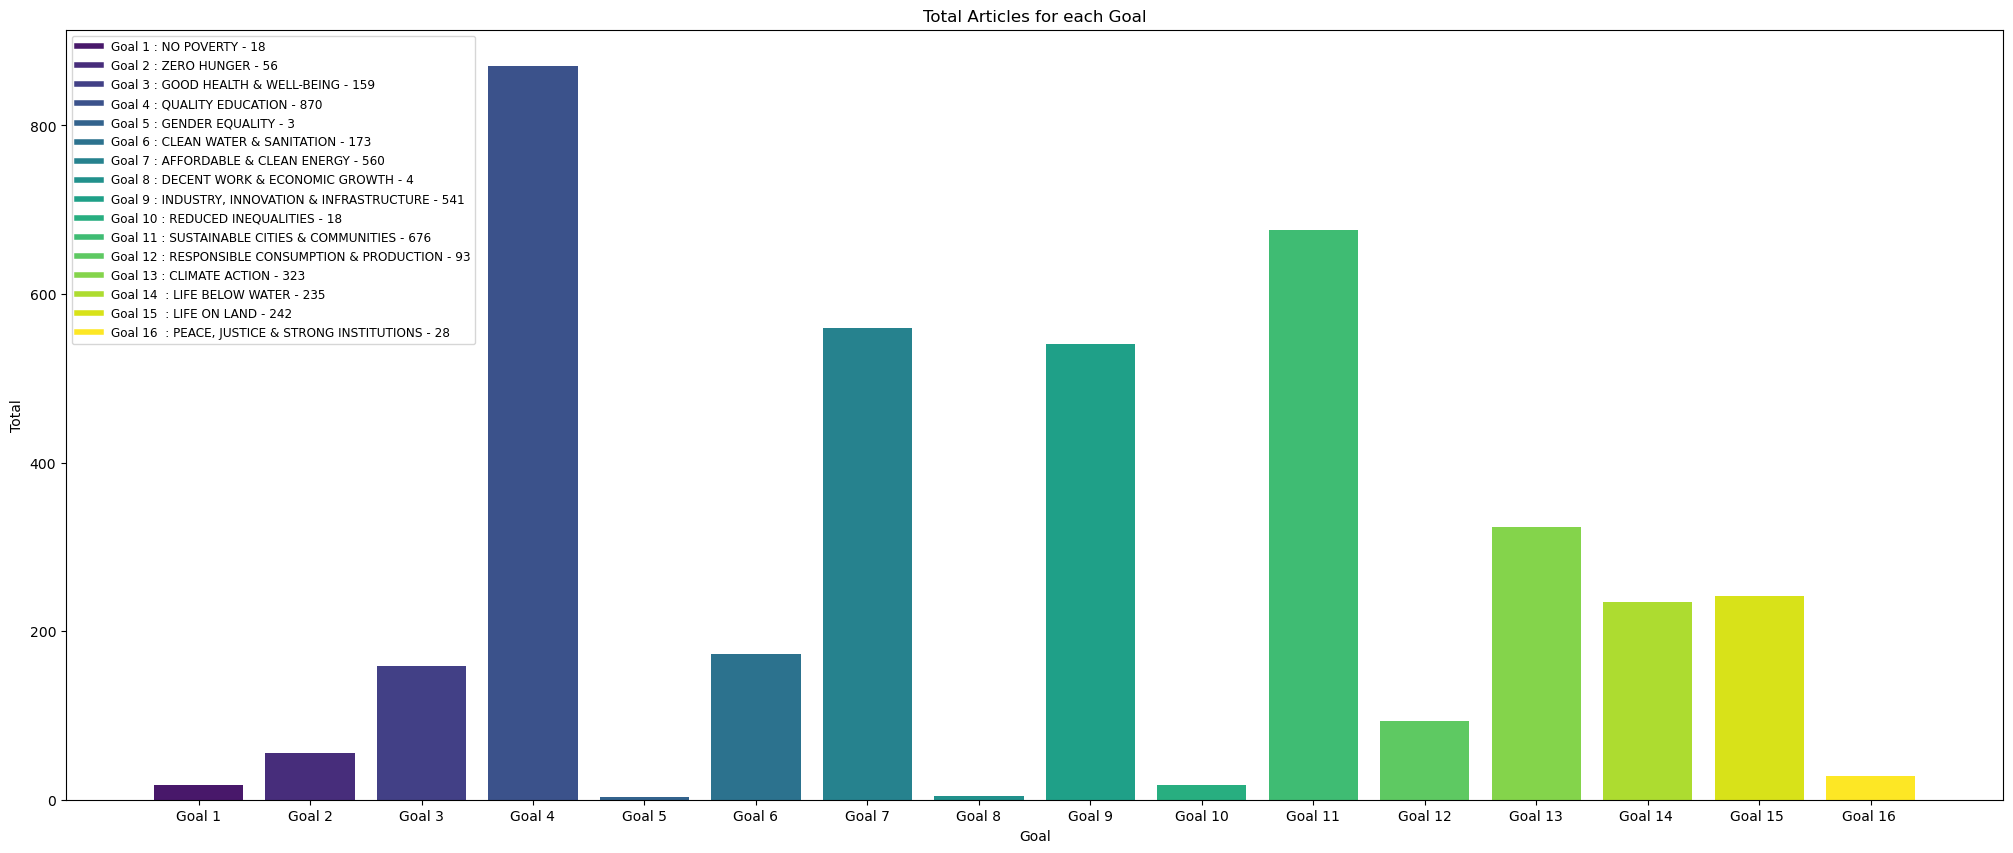

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(25, 10))

x = []
y = []
colors = [] 
labels = []
for key, value in goal_map.items():
    x.append(key)
    y.append(value['total'])
    labels.append(key + ' : ' + value['topic'] + ' - ' + str(value['total']))
    colors.append(plt.cm.viridis(len(labels) / len(goal_map)))

bars = plt.bar(x, y, color=colors)

legend_handles = []
for i, label in enumerate(labels):
    legend_handles.append(plt.Line2D([0], [0], color=colors[i], lw=4, label=label))

plt.legend(handles=legend_handles, loc='upper left', prop={'size': 8.7}, borderaxespad=0.5)
plt.xlabel('Goal')
plt.ylabel('Total')
plt.title('Total Articles for each Goal')
plt.show()

plt.savefig('bar_plot.png')

In [13]:
workbook = xlsxwriter.Workbook('result.xlsx')
for key, value in goal_map.items():
    worksheet = workbook.add_worksheet(key)
    bold = workbook.add_format({'bold': True})
    worksheet.write('A1', key, bold)
    worksheet.write('A2', value['topic'], bold)
    worksheet.write('A3', 'Total : ' + str(value['total']), bold)
    worksheet.write('A5', 'Article Number', bold)
    worksheet.write('B5', 'Article Title', bold)
    worksheet.write('C5', 'DOI', bold)
    worksheet.write('D5', 'IEEE Thesaurus Terms', bold)
    worksheet.write('E5', 'URL', bold)
    worksheet.write('F5', 'Score', bold)
    row = 6
    for article in value['articles']:
        worksheet.write('A' + str(row), article['article_number'])
        worksheet.write('B' + str(row), article['article_title'])
        worksheet.write('C' + str(row), article['doi'])
        worksheet.write('D' + str(row), article['ieee_thesaurus_terms'])
        worksheet.write('E' + str(row), article['url'])
        worksheet.write('F' + str(row), article['score'])
        row += 1
workbook.close()